In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Load the same dataset used in 02
df = pd.read_csv("../data/personal_finance_expenses.csv")

# 2) Recreate engineered features exactly as in 02
expense_cols = [
    'Rent','Loan_Repayment','Insurance','Groceries','Transport','Eating_Out',
    'Entertainment','Utilities','Healthcare','Education','Miscellaneous'
]
df['total_expenses']     = df[expense_cols].sum(axis=1)
df['estimated_savings']  = df['Income'] - df['total_expenses']

# 3) Target and features (drop target + Potential_Savings_*)
y = df['Desired_Savings']
X = df.drop(['Desired_Savings'] + [c for c in df.columns if 'Potential_Savings' in c], axis=1)

# 4) One-hot encode categoricals exactly like in 02
X = pd.get_dummies(X, columns=['Occupation','City_Tier'])

# 5) Same split as 02 (so results are comparable)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [2]:
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load artifacts saved in 02
lin = joblib.load("../models/savings_linear_reg.pkl")
lin_cols = joblib.load("../models/savings_linear_reg_columns.pkl")

# Align test features to the exact column order the model expects
X_test_lin = X_test.reindex(columns=lin_cols, fill_value=0)

# Predict
y_pred_lin = lin.predict(X_test_lin)

# Quick sanity metrics (same units as before)
mae_lin  = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin   = r2_score(y_test, y_pred_lin)
print(f"Linear — MAE: {mae_lin:.2f} | RMSE: {rmse_lin:.2f} | R^2: {r2_lin:.3f}")

Linear — MAE: 1311.21 | RMSE: 2314.66 | R^2: 0.926


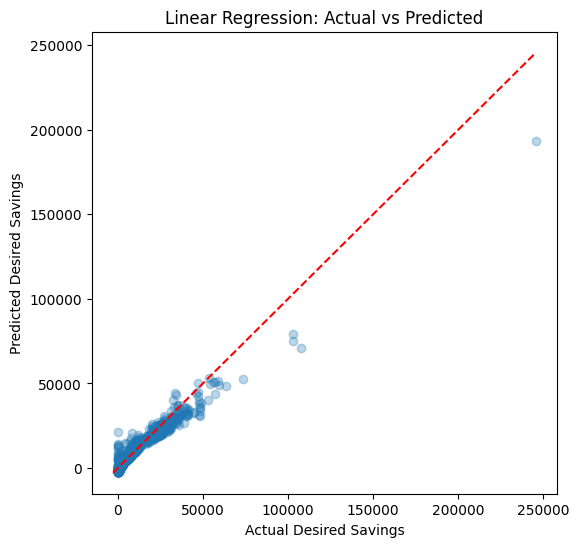

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lin, alpha=0.3)
low  = min(y_test.min(), y_pred_lin.min())
high = max(y_test.max(), y_pred_lin.max())
plt.plot([low, high], [low, high], 'r--')  # perfect prediction line
plt.xlabel("Actual Desired Savings")
plt.ylabel("Predicted Desired Savings")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

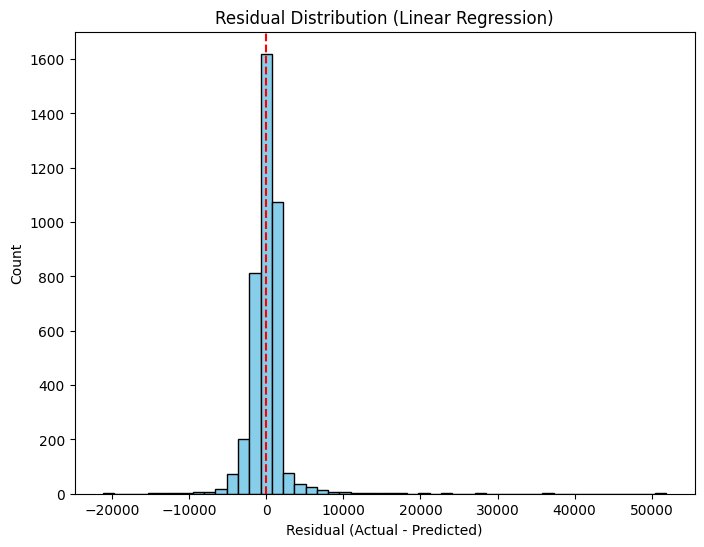

Residual mean: 52.031616961140735
Residual std: 2314.3625966932073
Min residual: -21207.486158408516
Max residual: 51889.742878765624


In [4]:
import numpy as np
import matplotlib.pyplot as plt

residuals_lin = y_test - y_pred_lin

plt.figure(figsize=(8,6))
plt.hist(residuals_lin, bins=50, color="skyblue", edgecolor="black")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution (Linear Regression)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()

print("Residual mean:", residuals_lin.mean())
print("Residual std:", residuals_lin.std())
print("Min residual:", residuals_lin.min())
print("Max residual:", residuals_lin.max())


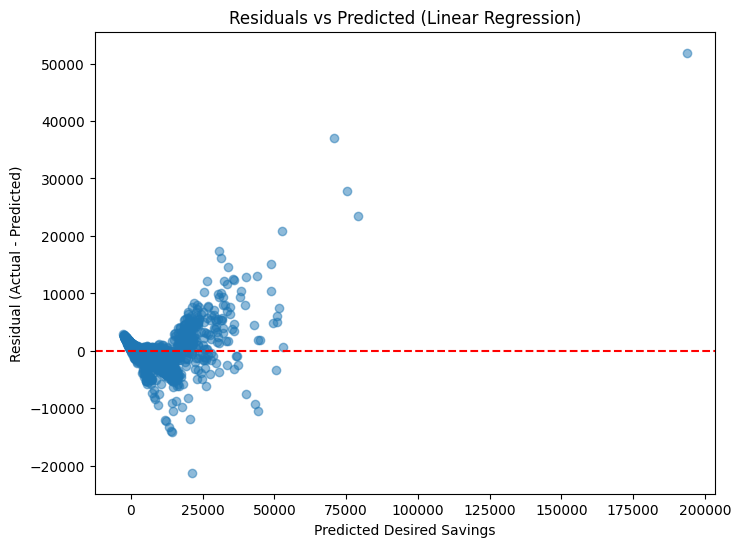

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred_lin, residuals_lin, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.xlabel("Predicted Desired Savings")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Reload XGBoost ---
xgb_loaded = joblib.load("../models/savings_xgb_reg.pkl")
xgb_columns = joblib.load("../models/savings_xgb_reg_columns.pkl")

# Align X_test to the schema the model was trained on
X_test_xgb = X_test.reindex(columns=xgb_columns, fill_value=0)

# Predict
y_pred_xgb = xgb_loaded.predict(X_test_xgb)

# Metrics
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb   = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — MAE: {mae_xgb:.2f} | RMSE: {rmse_xgb:.2f} | R^2: {r2_xgb:.3f}")


XGBoost — MAE: 147.84 | RMSE: 2648.44 | R^2: 0.903


In [9]:
import numpy as np

# Check a few rows
for i in [0, 1, 5, 10]:
    sample = X_test.iloc[[i]].reindex(columns=xgb_columns, fill_value=0)
    pred = xgb_loaded.predict(sample)[0]
    actual = y_test.iloc[i]
    error = pred - actual
    pct_error = (error / actual) * 100

    print(f"Row {i}")
    print(f"  Actual:    {actual:.2f}")
    print(f"  Predicted: {pred:.2f}")
    print(f"  Error:     {error:.2f} ({pct_error:.1f}%)\n")


Row 0
  Actual:    1577.91
  Predicted: 1599.66
  Error:     21.74 (1.4%)

Row 1
  Actual:    1972.33
  Predicted: 2005.38
  Error:     33.05 (1.7%)

Row 5
  Actual:    1202.87
  Predicted: 1175.07
  Error:     -27.81 (-2.3%)

Row 10
  Actual:    947.16
  Predicted: 936.07
  Error:     -11.09 (-1.2%)



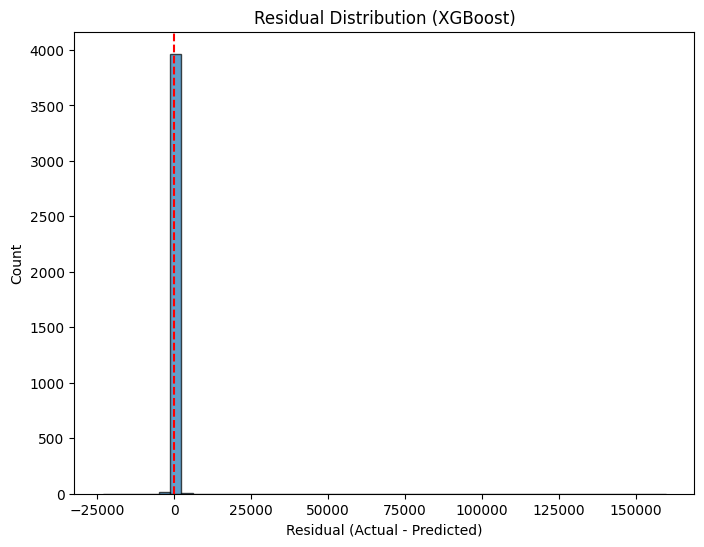

In [10]:
y_pred_xgb = xgb_loaded.predict(X_test)
residuals_xgb = y_test - y_pred_xgb

plt.figure(figsize=(8,6))
plt.hist(residuals_xgb, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(residuals_xgb.mean(), color="red", linestyle="--")
plt.title("Residual Distribution (XGBoost)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()


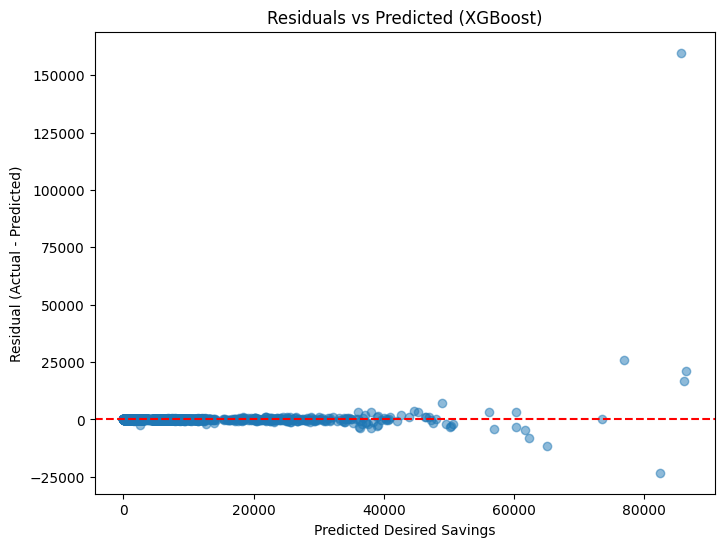

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted (XGBoost)")
plt.xlabel("Predicted Desired Savings")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()


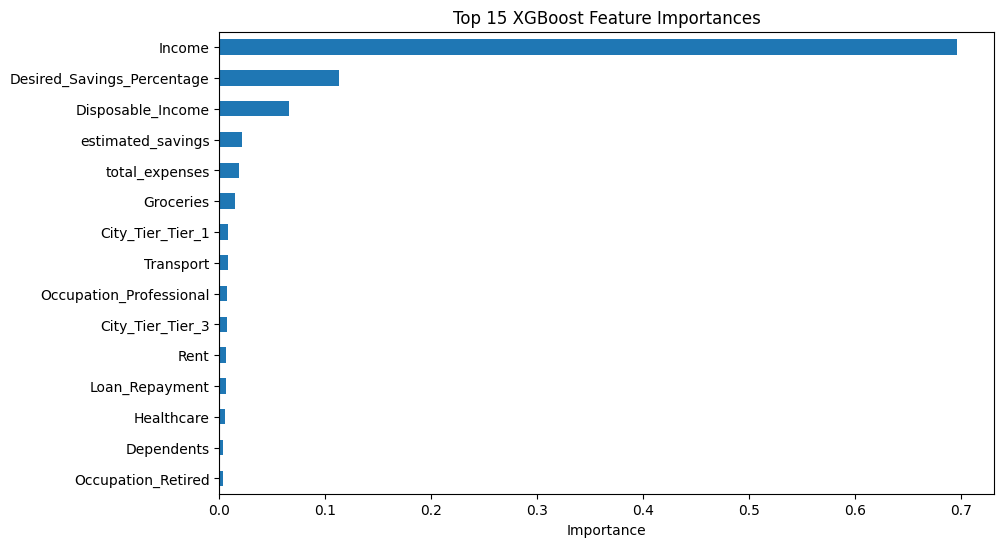

Income                        0.697034
Desired_Savings_Percentage    0.113132
Disposable_Income             0.066071
estimated_savings             0.021791
total_expenses                0.018110
Groceries                     0.014667
City_Tier_Tier_1              0.008138
Transport                     0.007950
Occupation_Professional       0.007226
City_Tier_Tier_3              0.007049
Rent                          0.006622
Loan_Repayment                0.006196
Healthcare                    0.005613
Dependents                    0.003583
Occupation_Retired            0.003094
dtype: float32


In [12]:
import pandas as pd

imp = pd.Series(xgb_loaded.feature_importances_, index=xgb_columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
imp.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 XGBoost Feature Importances")
plt.xlabel("Importance")
plt.show()

print(imp.head(15))


In [15]:
# Model comparision

import pandas as pd

comparison = pd.DataFrame({
    "metric": ["MAE", "RMSE", "R^2"],
    "Linear Regression": [mae_lin, rmse_lin, r2_lin],
    "XGBoost": [mae_xgb, rmse_xgb, r2_xgb]
})

print("Model Comparison:")
print(comparison)


Model Comparison:
  metric  Linear Regression      XGBoost
0    MAE        1311.208594   147.837080
1   RMSE        2314.658171  2648.443343
2    R^2           0.925836     0.902904


In [16]:
import pandas as pd
import numpy as np

# Outliers check. these are the worst cases

def residual_table(model_name, y_true, y_pred, X_slice, extra_cols=None, top_k=10):
    res = pd.DataFrame({
        "Actual": y_true.values,
        "Predicted": y_pred,
    }, index=y_true.index)
    res["Residual"] = res["Actual"] - res["Predicted"]
    res["AbsResidual"] = res["Residual"].abs()
    res["PctError"] = np.where(res["Actual"] != 0, res["Residual"]/res["Actual"]*100, np.nan)

    # attach a few intuitive context columns from original data
    cols = ["Income","total_expenses","estimated_savings"]
    if extra_cols: cols += extra_cols
    cols = [c for c in cols if c in X_slice.columns or c in df.columns]

    # try pulling from X (engineered features) first, else from df
    attach = {}
    for c in cols:
        if c in X_slice.columns:
            attach[c] = X_slice[c]
        elif c in df.columns:
            attach[c] = df.loc[X_slice.index, c]
    if attach:
        res = res.join(pd.DataFrame(attach))

    res = res.sort_values("AbsResidual", ascending=False).head(top_k)
    res.insert(0, "Model", model_name)
    return res

# align columns used by each model
X_test_lin_aligned = X_test.reindex(columns=lin_cols, fill_value=0)
X_test_xgb_aligned = X_test.reindex(columns=xgb_columns, fill_value=0)

# build tables
worst_lin = residual_table("Linear", y_test, y_pred_lin, X_test)
worst_xgb = residual_table("XGBoost", y_test, y_pred_xgb, X_test)

# show top offenders from each model
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")
print("Top 10 absolute errors — Linear")
display(worst_lin)

print("\nTop 10 absolute errors — XGBoost")
display(worst_xgb)


Top 10 absolute errors — Linear


,Model,Actual,Predicted,Residual,AbsResidual,PctError,Income,total_expenses,estimated_savings
15843,Linear,"245,504.49","193,614.74","51,889.74","51,889.74",21.14,"1,079,728.37","702,668.16","377,060.22"
8248,Linear,"107,809.45","70,807.55","37,001.90","37,001.90",34.32,"447,243.74","338,761.96","108,481.78"
6891,Linear,"103,065.02","75,238.14","27,826.88","27,826.88",27.00,"504,940.97","401,875.95","103,065.02"
13225,Linear,"102,732.70","79,260.24","23,472.45","23,472.45",22.85,"466,065.31","326,668.49","139,396.82"
4989,Linear,0.00,"21,207.49","-21,207.49","21,207.49",NaN,"203,341.15","205,291.21","-1,950.06"
19490,Linear,"73,565.18","52,687.16","20,878.03","20,878.03",28.38,"312,765.47","227,111.82","85,653.64"
4186,Linear,"48,202.12","30,831.40","17,370.72","17,370.72",36.04,"196,459.84","146,809.19","49,650.65"
7757,Linear,"47,678.17","31,460.38","16,217.80","16,217.80",34.02,"191,580.26","141,602.70","49,977.56"
13169,Linear,"63,758.93","48,690.53","15,068.40","15,068.40",23.63,"341,636.38","277,877.45","63,758.93"
19736,Linear,"48,566.56","33,924.10","14,642.46","14,642.46",30.15,"198,324.21","147,979.27","50,344.94"



Top 10 absolute errors — XGBoost


,Model,Actual,Predicted,Residual,AbsResidual,PctError,Income,total_expenses,estimated_savings
15843,XGBoost,"245,504.49","85,658.37","159,846.12","159,846.12",65.11,"1,079,728.37","702,668.16","377,060.22"
13225,XGBoost,"102,732.70","76,871.95","25,860.74","25,860.74",25.17,"466,065.31","326,668.49","139,396.82"
18363,XGBoost,"59,147.34","82,380.50","-23,233.16","23,233.16",-39.28,"329,954.91","243,936.06","86,018.85"
8248,XGBoost,"107,809.45","86,489.19","21,320.27","21,320.27",19.78,"447,243.74","338,761.96","108,481.78"
6891,XGBoost,"103,065.02","86,119.11","16,945.91","16,945.91",16.44,"504,940.97","401,875.95","103,065.02"
17627,XGBoost,"53,705.88","65,138.92","-11,433.04","11,433.04",-21.29,"302,993.63","195,718.02","107,275.60"
17436,XGBoost,"54,358.85","62,330.79","-7,971.94","7,971.94",-14.67,"357,292.15","302,933.30","54,358.85"
13206,XGBoost,"55,978.99","49,011.39","6,967.59","6,967.59",12.45,"357,261.68","301,282.69","55,978.99"
11226,XGBoost,"57,126.52","61,759.04","-4,632.52","4,632.52",-8.11,"263,235.99","196,014.00","67,221.99"
15208,XGBoost,"52,799.64","56,866.82","-4,067.18","4,067.18",-7.70,"260,314.51","188,055.27","72,259.24"


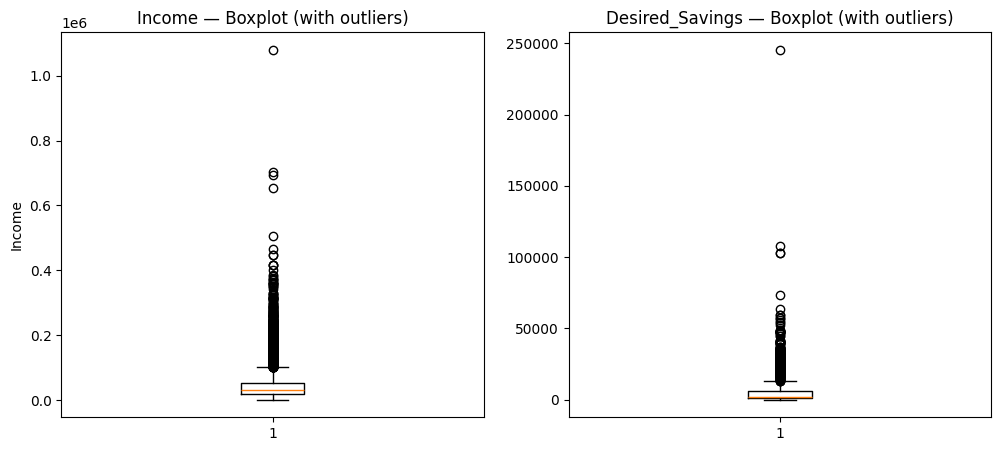

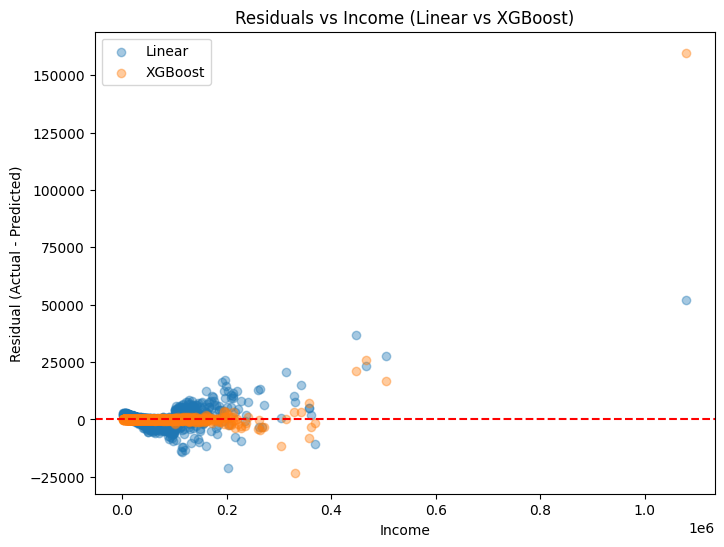

In [17]:
import matplotlib.pyplot as plt

# 1) Boxplots to see heavy tails
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].boxplot(df["Income"], vert=True, showfliers=True)
axes[0].set_title("Income — Boxplot (with outliers)")
axes[0].set_ylabel("Income")

axes[1].boxplot(y_test, vert=True, showfliers=True)
axes[1].set_title("Desired_Savings — Boxplot (with outliers)")
plt.show()

# 2) Error vs Income (for both models)
plt.figure(figsize=(8,6))
plt.scatter(df.loc[X_test.index, "Income"], (y_test - y_pred_lin), alpha=0.4, label="Linear")
plt.scatter(df.loc[X_test.index, "Income"], (y_test - y_pred_xgb), alpha=0.4, label="XGBoost")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Income")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Income (Linear vs XGBoost)")
plt.legend()
plt.show()
